In [1]:
from src.models.bounding_box import BoundingBox
from src.models.vertex import Vertex
from src.services.data_converter_service import DataConverterService
from src.services.image_display_serivce import ImageDisplayService
from src.services.line_detection_service import LineDetectionService

from config import config


"""
    getting a single datapoint from the dataset
"""

converter_service = DataConverterService() 
datapoint = converter_service.load_single_datapoint(str(7))

In [2]:
from src.services.predict_symbols_service import PredictSymbolsService
from src.models.symbol import Symbol
from src.utils.convert_points_to_bounding_box import convert_points_to_bounding_box


"""
    predict the symbol bounding boxes using the prediction service.
"""

predicted_symbol_results = []

predict_service = PredictSymbolsService(
    image_path=datapoint.image_path
)

prediction_results = predict_service.predict_bounding_boxes()

for index, pr in enumerate(prediction_results):
    symbol = Symbol(
        name=f"s-{str(index)}",
        label=pr[1],
        pointSrc=Vertex(x=pr[0][0], y=pr[0][1]),
        pointDest=Vertex(x=pr[0][2], y=pr[0][3])
    )

    predicted_symbol_results.append(symbol)


0: 704x1088 2 9s, 1 10, 1 21, 1 22, 1 27, 1 29, 1 30, 559.9ms
Speed: 31.9ms preprocess, 559.9ms inference, 1.0ms postprocess per image at shape (1, 3, 704, 1088)
time took to finish prediction: 4.426616191864014


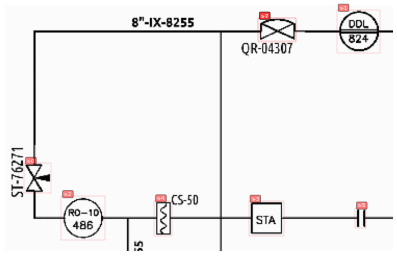

In [3]:
display_service = ImageDisplayService(
    datapoint.image_path,
    predicted_symbol_results
)
display_service.display_image_with_bbox(color='red', dpi=50)

In [4]:
from src.utils.calculate_distance import calculate_distance

"""
    remove redundent bounding boxes.
"""

index_to_delete = []

for index_1, s1 in enumerate(predicted_symbol_results):
    for index_2, s2 in enumerate(predicted_symbol_results[index_1 + 1:]): 
        if(
            calculate_distance(
                [*s1.pointSrc.get_dimensions(), *s1.pointDest.get_dimensions()], 
                [*s2.pointSrc.get_dimensions(), *s2.pointDest.get_dimensions()]                
            ) < 5
        ):
            index_to_delete.append(index_1)


predicted_symbol_results = [value for i, value in enumerate(predicted_symbol_results) if i not in list(set(index_to_delete))]

In [5]:
# line detection and their extension from the datapoint
line_detection_service = LineDetectionService(
    image_path=datapoint.image_path,
    bounding_boxes=[*predicted_symbol_results, *datapoint.words],
)

line_segments = [convert_points_to_bounding_box(l) for l in line_detection_service.extend_lines(
    line_detection_service.detect_line_segments(enable_thining=True)
)]

for index, l in enumerate(line_segments):
    l.name = f"l-{str(index)}"

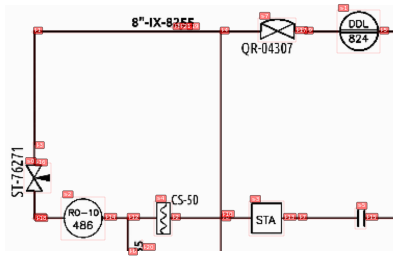

In [6]:
line_display_service = ImageDisplayService(
    datapoint.image_path,
    [*line_segments, *predicted_symbol_results]
)

line_display_service.display_image_with_bbox(color='red', dpi=50)

In [7]:
from src.services.graph_construction_service import GraphConstructionService

graph_service = GraphConstructionService(predicted_symbol_results, line_segments)
graph_service.initialize_graph()
graph_service.define_graph_edges()

<Figure size 640x480 with 0 Axes>

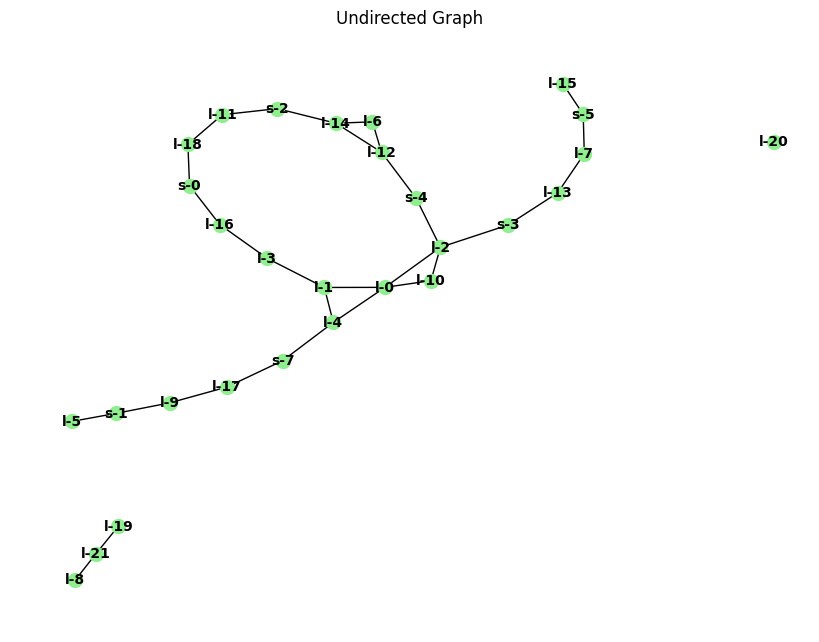

In [8]:
service = ImageDisplayService()
service.display_graph(graph_service.graph)

In [9]:
graph_service.get_line_cycle_list()

[['l-0', 'l-1', 'l-4'], ['l-0', 'l-2', 'l-10'], ['l-12', 'l-6', 'l-14']]

In [11]:
graph_service.reduce_line_cycles()
graph_service.set_largest_graph_connected_nodes()

<Figure size 640x480 with 0 Axes>

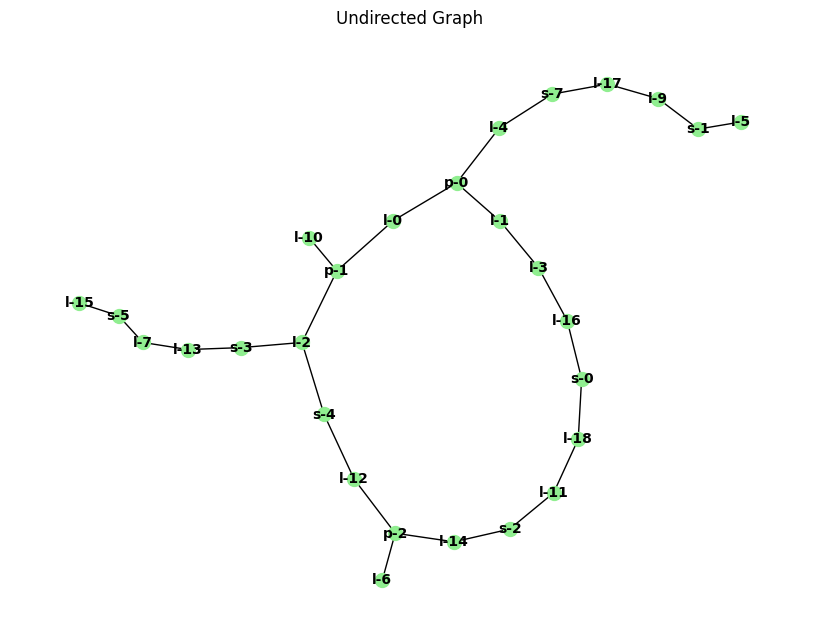

In [12]:
service.display_graph(graph_service.graph)

In [13]:
# this function has potential bugs.
graph_service.remove_unnecessary_lines()

<Figure size 640x480 with 0 Axes>

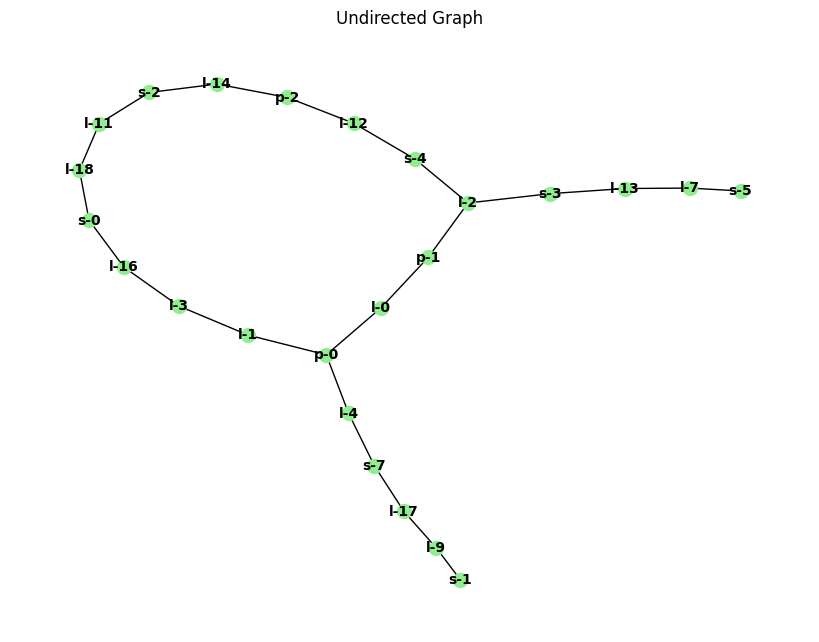

In [15]:
service.display_graph(graph_service.graph)

24